# Drizzle 1a: basic setup with super resolution

This is the same basic drizzle setup code as in script Drizzle 1, but using super resolution.

Using 2X super resoluion.

In [1]:
# %matplotlib ipympl

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from drizzle import cdrizzle
import rawpy

from datapath import DATA

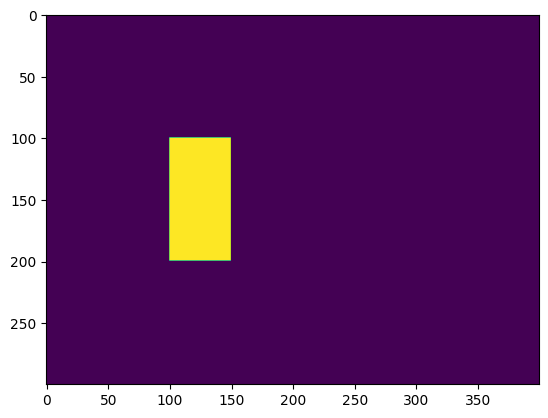

In [2]:
# simple test image - make it non-square so as to test the pixmap shaping algorithm
sizey = 300
sizex = 400
data = np.zeros((sizey, sizex), dtype='float32')
weights = np.ones((sizey, sizex), dtype='float32')

# image made of zeros, except for a rectangular area with ones
data[100:200, 100:150] = 1

# plt.imshow(data[90:110,90:110], vmin=0, vmax=1)
plt.imshow(data, vmin=0, vmax=1)

## Duplicate array size

In [3]:
super_resolution_factor = 2

kernel = np.ones((super_resolution_factor, super_resolution_factor), dtype=int)

data_two = np.ndarray.astype(np.kron(data, kernel), dtype='float32')
weights_two = np.ndarray.astype(np.kron(weights, kernel), dtype='float32')

sizey_two = sizey * super_resolution_factor
sizex_two = sizex * super_resolution_factor

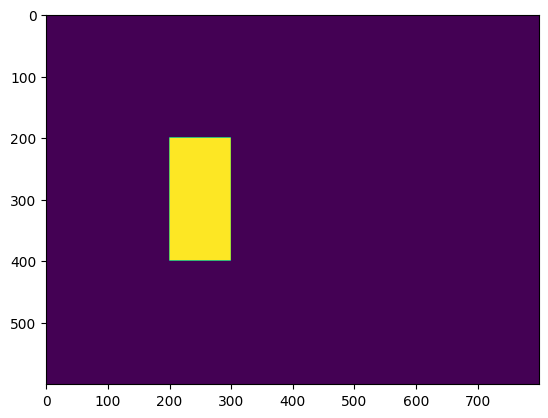

In [4]:
plt.imshow(data_two, vmin=0, vmax=1)

## Build pixmap

Initial pixmap for the augmented image is basically the same pixmap for the original 1X drizzle, with every pixel content multiplied by 2. In a subsequent step, we will add intra-pixel offsets to the initial pixmap.

In [5]:
idxmap = np.indices((sizex_two, sizey_two), dtype='float64')

# in original 1X image, we moved 100.3 in X and 50.5 in Y
idxmap[0] += 100.3 * super_resolution_factor
idxmap[1] +=  50.5 * super_resolution_factor

idxmap = idxmap.transpose()
idxmap = idxmap.reshape(sizex_two * sizey_two, 2)
pixmap = idxmap.reshape(sizey_two, sizex_two, 2)

## Allocate output arrays, and drizzle

In [6]:
# allocate output arrays
output_data = np.zeros((sizey_two, sizex_two), dtype='float32')
output_counts = np.zeros((sizey_two, sizex_two), dtype='float32')
output_context = np.zeros((sizey_two, sizex_two), dtype='int32')

# call C core drizzle algorithm
cdrizzle.tdriz(data_two, weights_two, pixmap, output_data, output_counts, output_context)

('Callable C-based DRIZZLE Version 1.12 (28th June 2018)', 180600, 99)

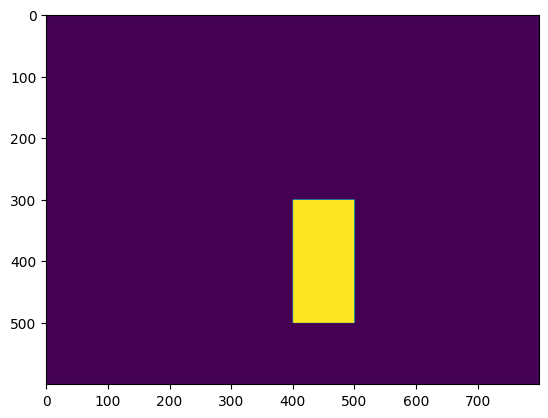

In [7]:
# plt.imshow(output_data[140:160,140:160], vmin=0, vmax=1)
plt.imshow(output_data, vmin=0, vmax=1)

## Super resolution on real image

Same image and code as in script Drizzle 1, but with super resolution mods.

In [8]:
# reference image used in the Offsets_X scripts. Offsets are defined against this image.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03770.ARW')
raw = rawpy.imread(fname)
reference_imarray = raw.raw_image_visible.astype(float)

# last image in sequence. This should have the largest offsets.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03829.ARW')
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

In [9]:
# relevant sizes
sizex = imarray.shape[1]
sizey = imarray.shape[0]

In [10]:
# define slice for displaying a small subset of each image. This slice is the same as used in Drizzle 1,
# but because it's applied to the double-sized arays, the index values are double what they are in Drizzle 1.
aslice = np.index_exp[2200:2600,3800:4200]

In [11]:
# this code is specific for a factor 2 super resolution
super_resolution_factor = 2

sizex_two = sizex * super_resolution_factor
sizey_two = sizey * super_resolution_factor

In [12]:
# duplicate input image array sizes
kernel = np.ones((super_resolution_factor, super_resolution_factor), dtype=int)

imarray_two = np.ndarray.astype(np.kron(imarray, kernel), dtype='float32')
reference_imarray_two = np.ndarray.astype(np.kron(reference_imarray, kernel), dtype='float32')

In [13]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray_two[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(imarray_two[aslice], vmin=500, vmax=1500)

### Pixel offsets with super resolution factor

In [14]:
# pixel offsets come from matching offsets file built by Offsets_X set of scripts.
fname_offsets = fname.replace('ARW', 'offsets.fits')

f = fits.open(fname_offsets)
offsets_x = f[1].data
offsets_y = f[2].data
f.close()

In [15]:
# offsets for super resolution array are generated from original offsets by adding
# intra-pixel offsets to each super-resolution pixel.
#
# This calculation assumes 2X2 super resolution.

# blow up offsets arrays to twice their size by duplicating offsets values
kernel = np.ones((super_resolution_factor, super_resolution_factor), dtype=int)
offsets_x_two = np.ndarray.astype(np.kron(offsets_x, kernel), dtype='float32')
offsets_y_two = np.ndarray.astype(np.kron(offsets_y, kernel), dtype='float32')

# offsets in the super resolution array are twice as much as in the original image
offsets_x_two *= 2.
offsets_y_two *= 2.

# But each individual offset in each of the 2x2 cells in the duplicated array, must
# be corrected by an intra-pixel offset.
_x = [-0.5, 0.5]   # row array
intrapixel_offsets_x = np.tile(_x, (offsets_x_two.shape[0], offsets_x.shape[1]))
_y = [[-0.5], [0.5]]   # column array
intrapixel_offsets_y = np.tile(_y, (offsets_y.shape[0], offsets_y_two.shape[1]))

# add intra_pixel offsets to original, expanded offsets
offsets_x_two += intrapixel_offsets_x
offsets_y_two += intrapixel_offsets_y

In [16]:
# build pixmap with "map into itself" data
idxmap = np.indices((imarray_two.shape[1], imarray_two.shape[0]), dtype='float64')

# add offsets  
idxmap[0] -= offsets_x_two.transpose()
idxmap[1] -= offsets_y_two.transpose()

# reshape to the format that cdrizzle understands
idxmap = idxmap.transpose()
idxmap = idxmap.reshape(imarray_two.shape[1] * imarray_two.shape[0], 2)
pixmap = idxmap.reshape(imarray_two.shape[0], imarray_two.shape[1], 2)

# weigths and auxiliary output arrays (not used for now)
weights_two = np.ones((sizey_two, sizex_two), dtype='float32')
output_counts = np.zeros(imarray_two.shape, dtype='float32')
output_context = np.zeros(imarray_two.shape, dtype='int32')

# main cdrizzle output array
output_data = np.zeros(imarray_two.shape, dtype='float32')

In [17]:
# we cannot use directly the array generated by rawpy, as input to cdrizzle (it barfs).
# Generate zeroed numpy array and add the rawpy array into it.
imarray_f_two = np.zeros(imarray_two.shape, dtype='float32')
imarray_f_two += imarray_two

In [18]:
# call C core drizzle algorithm
cdrizzle.tdriz(imarray_f_two, weights_two, pixmap, output_data, output_counts, output_context)

('Callable C-based DRIZZLE Version 1.12 (28th June 2018)', 859721, 0)

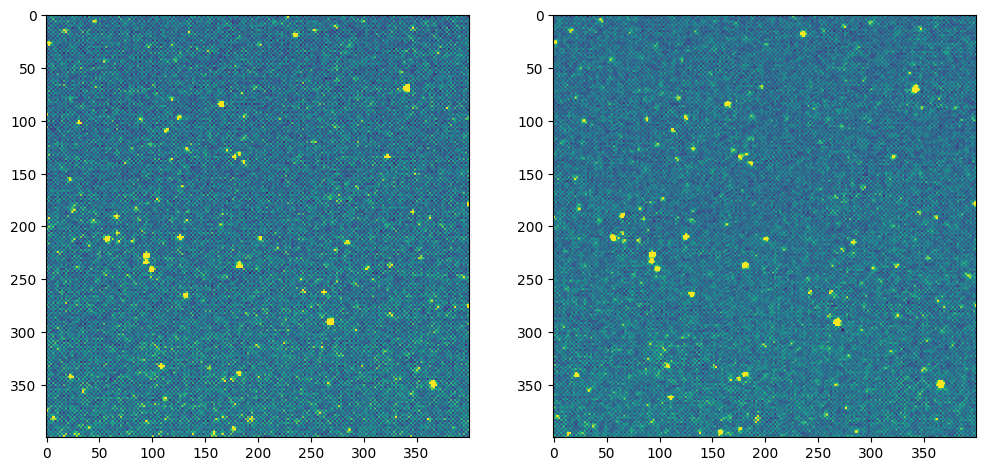

In [19]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray_two[aslice], vmin=500, vmax=1500)
# plt.imshow(imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(output_data[aslice], vmin=500, vmax=1500)

## Drizzle and co-add a set of images

As in Drizzle 1, we capture the procedure above into a function.

In [20]:
def drizz(filename, output_array, weights, output_counts, output_context):
    super_resolution_factor = 2

    # read input
    raw = rawpy.imread(filename)
    imarray = raw.raw_image_visible.astype(float)
    
    # blow up input array to twice its size by duplicating neighbor pixels
    kernel = np.ones((super_resolution_factor, super_resolution_factor), dtype=int)
    imarray_two = np.ndarray.astype(np.kron(imarray, kernel), dtype='float32')

    # read offsets
    fname_offsets = filename.replace('ARW', 'offsets.fits')
    f = fits.open(fname_offsets)
    offsets_x = f[1].data
    offsets_y = f[2].data
    f.close()

    # blow up offsets arrays to twice their size by duplicating offsets values
    offsets_x_two = np.ndarray.astype(np.kron(offsets_x, kernel), dtype='float32')
    offsets_y_two = np.ndarray.astype(np.kron(offsets_y, kernel), dtype='float32')

    # offsets in the super resolution array are twice as much as in the original image
    offsets_x_two *= 2.
    offsets_y_two *= 2.

    # But each individual offset in each of the 2x2 cells in the duplicated array, must
    # be corrected by an intra-pixel offset.
    _x = [-0.5, 0.5]   # row array
    intrapixel_offsets_x = np.tile(_x, (offsets_x_two.shape[0], offsets_x.shape[1]))
    _y = [[-0.5], [0.5]]   # column array
    intrapixel_offsets_y = np.tile(_y, (offsets_y.shape[0], offsets_y_two.shape[1]))

    # add intra_pixel offsets to original, expanded offsets
    offsets_x_two += intrapixel_offsets_x
    offsets_y_two += intrapixel_offsets_y 

    # build pixmap with "map into itself" data
    idxmap = np.indices((imarray_two.shape[1], imarray_two.shape[0]), dtype='float64')    

    # add offsets  
    idxmap[0] -= offsets_x_two.transpose()
    idxmap[1] -= offsets_y_two.transpose()

    # reshape for drizzle
    idxmap = idxmap.transpose()
    idxmap = idxmap.reshape(imarray_two.shape[1] * imarray_two.shape[0], 2)
    pixmap = idxmap.reshape(imarray_two.shape[0], imarray_two.shape[1], 2)

    # generate zeroed array and add the rawpy array to it.
    imarray_two_copy = np.zeros(imarray_two.shape, dtype='float32')
    imarray_two_copy += imarray_two
            
    # call C core drizzle algorithm
    cdrizzle.tdriz(imarray_two_copy, weights, pixmap, output_array, output_counts, output_context, kernel="turbo")

Now, loop over images and co-add them.

In [21]:
# list of image names to be processed
path = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')
list_p = glob.glob(path + '/*.ARW')
list_p.sort()

# arrays used by drizzle
weights = np.ones(imarray_two.shape, dtype='float32')
output_counts = np.zeros(imarray_two.shape, dtype='float32')
output_context = np.zeros(imarray_two.shape, dtype='int32')

# reference image; in this case is the first in list. This depends on how
# the Offsets_X scripts were configured!
fname = list_p[0]
raw = rawpy.imread(fname)
reference_imarray = raw.raw_image_visible.astype(float)

# blow up reference image 
kernel = np.ones((super_resolution_factor, super_resolution_factor), dtype=int)
reference_imarray_two = np.ndarray.astype(np.kron(reference_imarray, kernel), dtype='float32')

# the sum is made on top of the already existing reference image array
coadded_two = np.zeros(imarray_two.shape, dtype='float32')
coadded_two += reference_imarray_two

for fname in list_p[1:]:
    print(fname)
    output_array_two = np.zeros(imarray_two.shape, dtype='float32')

    drizz(fname, output_array_two, weights, output_counts, output_context)
    
    coadded_two += output_array_two

# average result
# coadded /= len(list_p)    

/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03771.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03772.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03773.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03774.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03775.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03776.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03777.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03778.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800

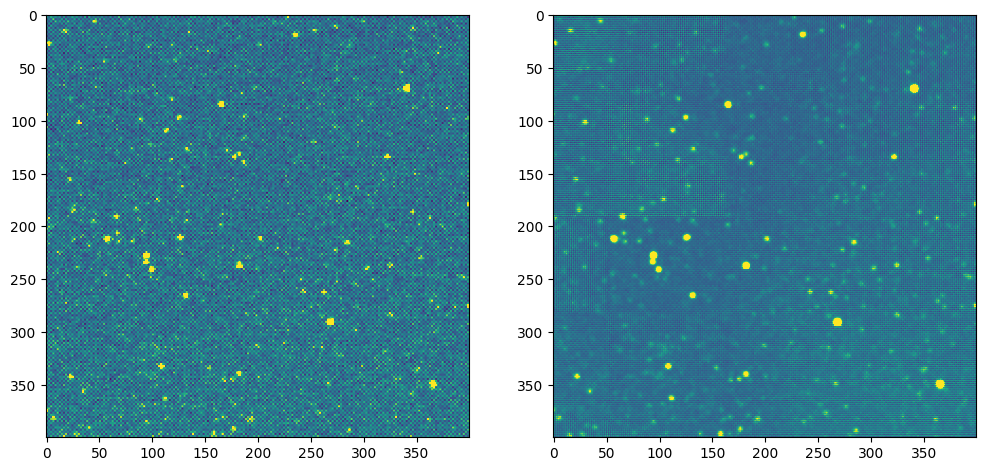

In [22]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray_two[aslice],  vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(coadded_two[aslice], vmin=3000, vmax=8500)